<img src="./images/Logos.jpg" title="Institutional Logos" width="70%">

# Heat Waves | Warm-up 02: Integration Test of CLIMADA Impact Assessment with Copernicus Climate Change Service (C3S) data (V3)

### About

Welcome to this tutorial, which guides you through analysing heat stress impacts using CLIMADA in the context of the U-CLIMADAPT project (User-centric Assessment of Climate Change Impacts for Adaptation). This tutorial is part of a series of four, focusing on *01 Heat Waves|Installation and Data Access, 02 Heat Waves|Warm-up, 03 Heat Waves|Scenario, Heat Stress, and 04 Heat Waves | Uncertainty and Sensitivity*. This is the continuation of the first tutorial in the series, where users learned to find and explore data from the Copernicus Climate Data Store (CDS), install the Copernicus API for direct data downloads, and set up CLIMADA.

In this second tutorial, we focus on the Warm-up phase, where you will perform your first large exercise to understand the pipeline in CLIMADA ETH. You will learn how to handle hazard, exposure, and vulnerability data and integrate them to assess the socio-economic impacts of climate hazards like heatwaves. This tutorial serves as a foundational step before proceeding to more advanced scenarios and sensitivity analyses in subsequent parts of the series.

### About U-CLIMADAPT

The U-CLIMADAPT project is a collaborative effort led by the Working Group "Impact of Climate Change." Its primary goal is to provide refined climate impact assessments tailored to specific requirements. To achieve this, it leverages the power of climate forecasts and projections from C3S's Climate Data Store (CDS) while also integrating Copernicus land-use and satellite data

### Integrating CLIMADA and Copernicus Data

U-CLIMADAPT integrates Copernicus Climate Data Store (CDS) datasets with CLIMADA to create a powerful tool for assessing the socioeconomic impacts of climate hazards. By combining Copernicus data on extreme heat, floods, drought, and more with CLIMADA’s modeling capabilities, users can estimate risks to populations, infrastructure, and assets, enabling data-driven climate adaptation strategies.

### Tutorial Overview

Now, let's dive into the tutorial itself. We will guide you through the following steps:

- Inspect the input data from CDS.
- Set up the hazard, focusing on heat stress.
- Estimate the exposure to heat stress in your chosen area.
- Define vulnerability and calculate the potential damage.
- Explore all the plotting and visualisation options between CLIMADA.

By following this tutorial, you will gain hands-on experience and unlock the potential of integrating CLIMADA with C3S data from Copernicus. Let's get started!

<br>

### Acknowledgements

- **Script Author**: [Dahyann Araya](https://github.com/DahyannAraya?tab=repositories)
- **Reviewer**: [Timo Schmid](https://github.com/timschmi95), [Tat Chi Wong](https://github.com/wongtaeth)

In [1]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

# Disable warnings for data download via API
import urllib3

urllib3.disable_warnings()

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, module="shapely.predicates")
warnings.filterwarnings(
    "ignore", category=RuntimeWarning, module="shapely.constructive"
)

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [2]:
import os

# Set the data directory within the user's Documents directory
DATADIR = os.path.join(os.path.expanduser("~/Documents"), "test_data")
os.makedirs(DATADIR, exist_ok=True)
print(f"Data will be saved in: {DATADIR}")

Data will be saved in: C:\Users\jimmy/Documents\test_data


In [3]:
from climada import CONFIG

KEY = str(CONFIG.cds_api_key)

In [4]:
current_directory = os.getcwd()

# Print the current directory
print("Current Directory:", current_directory)

Current Directory: C:\Users\jimmy\Documents\RA\CDS_Warm_up\CDS_Warm_Up


# Inspect data

Now that we have downloaded the data from the previous notebook let's call the data to start the analysis of heat waves. The first thing we do is to inspect the data and understand it. We have requested the data in NetCDF (network Common Data Form) format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the [Xarray](http://xarray.pydata.org/en/stable/) library. Xarray is an open-source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an [xarray.Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [5]:
import tarfile

tar_file = f"{DATADIR}/sis-heat-and-cold-spells.tar.gz"

# Print files names and extract
with tarfile.open(tar_file, "r:gz") as file:
    print(file.getnames())
    file.extractall(DATADIR)

['HWD_EU_health_rcp85_mean_v1.0.nc']


In [6]:
hwd_eu_rcp85_mean = f"{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc"
hwd_eu_rcp85_mean

'C:\\Users\\jimmy/Documents\\test_data/HWD_EU_health_rcp85_mean_v1.0.nc'

In [7]:
import xarray as xr

ds = xr.open_dataset(hwd_eu_rcp85_mean)
ds

<xarray.Dataset> Size: 102MB
Dimensions:        (lat: 425, lon: 599, time: 100)
Coordinates:
    height         float64 8B ...
  * lat            (lat) float64 3kB 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon            (lon) float64 5kB -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time           (time) datetime64[ns] 800B 1986-01-01 ... 2085-01-01
Data variables:
    HWD_EU_health  (time, lat, lon) float32 102MB ...
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 12:30:06 2019
    institution:    VITO (https://vito.be/en)

In [8]:
# Extract variable
hwd_eu_rcp85_mean = ds["HWD_EU_health"]

In [9]:
# Shape and sizes
print(hwd_eu_rcp85_mean.shape)
print(hwd_eu_rcp85_mean.size)

(100, 425, 599)
25457500


## Plot the data

Now we will see how we can get a better understanding of the data by visualising a specific time step. With the help of [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [Matplotlib](https://matplotlib.org/stable/index.html), we will create a cartographic chart. By setting the [Plate Carrée](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#platecarree) projection, we ensure an accurate geographical representation. Next, we create a figure with axes to prepare the graph. Using the `isel()` function, we will select the desired time step and plot it using the built-in `plot()` function provided by xarray. To provide additional context, we will add coastlines and gridlines to the graph. Finally, we will display the plot, allowing us to explore and analyse the data effectively.

In [10]:
import cartopy.crs as ccrs

# Set projection to PlateCarree EPSG:4326
proj = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": proj})

# Plot the data isel() method. Here time=98 retrieves data corresponding to the 99th time step
# This is because in Python, the indice of the first element starts from 0
hwd_eu_rcp85_mean.isel(time=98).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Reds")

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
plt.show()

In [11]:
# Time Map Plotting and Saving Loop of heat waves

# Set projection to PlateCarree EPSG:4326
proj = ccrs.PlateCarree()

# Loop through the desired time range
for t in range(100):
    # Create a new figure and axes for each time step
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": proj})

    # Plot the data for the current time step
    data = hwd_eu_rcp85_mean.isel(time=t)
    data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Reds")

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()

    # Set a title for the plot
    ax.set_title(f"Time Step: {t+1}")

    # Save the plot as a PNG file
    plt.savefig(os.path.join(DATADIR, f"time_map_{t+1}.png"))

    # Close the figure to free up resources
    plt.close(fig)

## Start estimating the impact via CLIMADA

# Set up hazard

## Set a heat wave hazard 

In this first exercise, our goal is to analyze the heatwave hazard in Europe using the [heatwave days dataset from Copernicus](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview). The dataset provides information for different future time periods and considers climate change scenarios, specifically RCP 8.5 and 4.6.

A bias-adjusted EURO-CORDEX dataset offers temperature data from 1971 to 2100. By averaging the statistics over 30-year intervals, a smoothed mean time series spanning 1986 to 2085 is obtained. The dataset provides annual heatwave days data with a resolution of 0.1° in latitude and longitude, equivalent to approximately 11 kilometers at the equator.

By conducting this exercise, we aim to gain insights into the long-term heatwave trends in Europe, considering future projections and climate change scenarios. This analysis can contribute to a better understanding of the potential impacts of heatwaves on the region and inform relevant mitigation and adaptation strategies.

>**Important:** CLIMADA currently operates using the EPSG:4326 projection, also known as WGS 84. To ensure compatibility, your data must be transformed to this coordinate system. Support for additional coordinate systems will be added in the near future.

>**Note**: CLIMADA uses sparse matrices for computational and memory efficiency. Sparse matrices store only non-zero elements, saving memory and speeding up calculations, especially for large datasets. This approach enhances scalability and flexibility, allowing the model to handle larger and more complex problems efficiently. It also facilitates integration with other scientific computing tools.


>**Note:** Please be aware that in CLIMADA, any missing, Not Applicable or "NA" values in the hazard matrix will be substituted with zeros.

>**Tip:** If you only want to know how much of the population has been or will be affected by heatwaves, you can convert the continuous heatwave values to binary data. This way, you will know whether or not the population is affected by heatwaves without having to consider the magnitude of the heatwaves.

>**Tip:** If you only want to see the content of a hazard you can use **print(dir(hazard))**

In [12]:
# Create a hazard

from climada.hazard import Hazard

hwd_eu_rcp85_mean = f"{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc"
hazard = Hazard.from_xarray_raster_file(
    f"{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc",
    hazard_type="Heat_waves_days",
    intensity_unit="days",
    intensity="HWD_EU_health",
    coordinate_vars=dict(event="time", longitude="lon", latitude="lat"),
)
hazard.check()

hazard.event_name = list(map(lambda x: pd.Timestamp(x).isoformat(), hazard.event_name))

# Access hazard attributes
print("Hazard attributes:")
print(" - Shape of intensity (time, gridpoint):", hazard.intensity.shape)
print(" - Centroids:", hazard.centroids.shape)
print(" - Units:", hazard.units)
print(" - event_id:", hazard.event_id)
print(" - frequency:", hazard.frequency)
print(" - min, max fraction:", hazard.fraction.min(), hazard.fraction.max())
print(" - Date:", hazard.date)
print("min, max fraction: ", hazard.fraction.min(), hazard.fraction.max())
print(" - event_name:")
hazard.event_name

Hazard attributes:
 - Shape of intensity (time, gridpoint): (100, 254575)
 - Centroids: (425, 599)
 - Units: days
 - event_id: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
 - frequency: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
 - min, max fraction: 0.0 0.0
 - Date: [725007 725372 725737 726103 726468 726833 727198 727564 727929 728294
 728659 729025 729390 729755 730120 

['1986-01-01T00:00:00',
 '1987-01-01T00:00:00',
 '1988-01-01T00:00:00',
 '1989-01-01T00:00:00',
 '1990-01-01T00:00:00',
 '1991-01-01T00:00:00',
 '1992-01-01T00:00:00',
 '1993-01-01T00:00:00',
 '1994-01-01T00:00:00',
 '1995-01-01T00:00:00',
 '1996-01-01T00:00:00',
 '1997-01-01T00:00:00',
 '1998-01-01T00:00:00',
 '1999-01-01T00:00:00',
 '2000-01-01T00:00:00',
 '2001-01-01T00:00:00',
 '2002-01-01T00:00:00',
 '2003-01-01T00:00:00',
 '2004-01-01T00:00:00',
 '2005-01-01T00:00:00',
 '2006-01-01T00:00:00',
 '2007-01-01T00:00:00',
 '2008-01-01T00:00:00',
 '2009-01-01T00:00:00',
 '2010-01-01T00:00:00',
 '2011-01-01T00:00:00',
 '2012-01-01T00:00:00',
 '2013-01-01T00:00:00',
 '2014-01-01T00:00:00',
 '2015-01-01T00:00:00',
 '2016-01-01T00:00:00',
 '2017-01-01T00:00:00',
 '2018-01-01T00:00:00',
 '2019-01-01T00:00:00',
 '2020-01-01T00:00:00',
 '2021-01-01T00:00:00',
 '2022-01-01T00:00:00',
 '2023-01-01T00:00:00',
 '2024-01-01T00:00:00',
 '2025-01-01T00:00:00',
 '2026-01-01T00:00:00',
 '2027-01-01T00:

We can also visualize the hazard; in this case, we will visualize the hazard for events 1 and 99.

<GeoAxes: title={'center': 'Event ID 99: 2084-01-01T00:00:00'}>

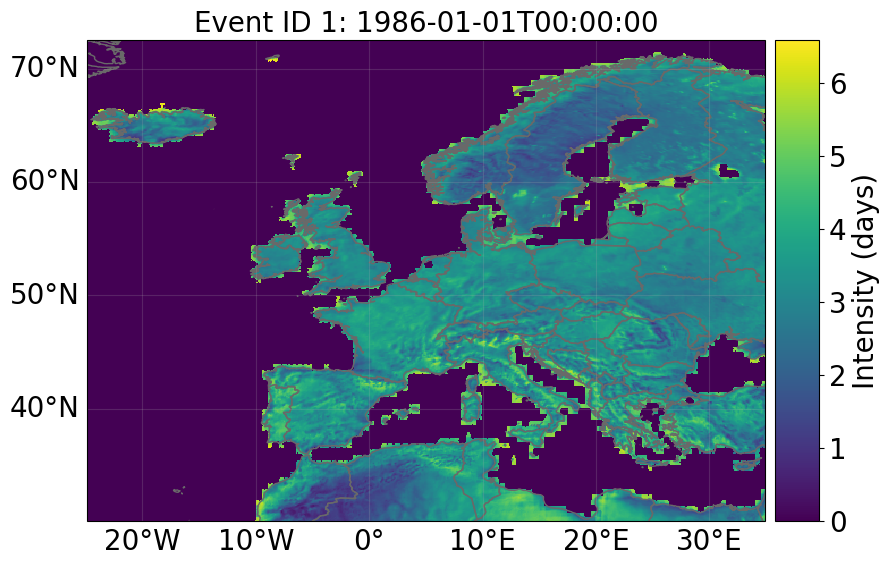

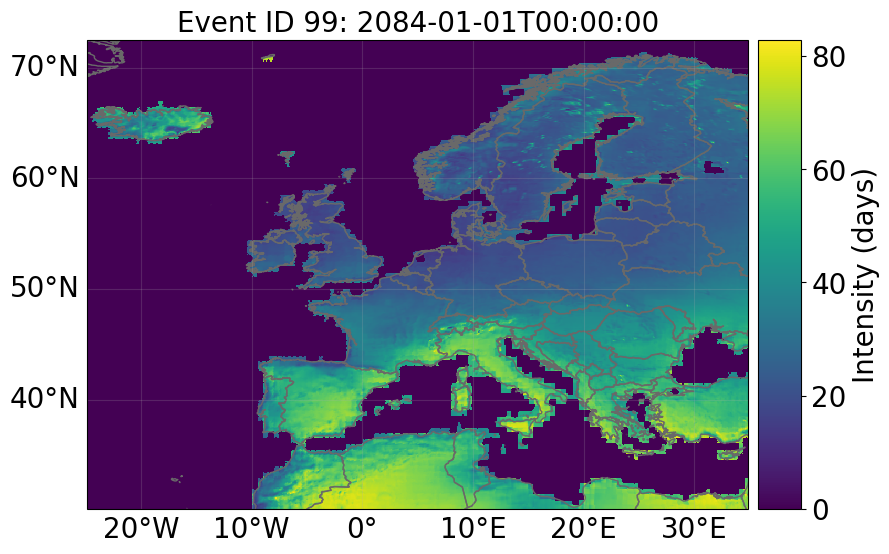

In [13]:
# Plot the intensity of the first event
hazard.plot_intensity(
    1, smooth=False
)  # if smooth=True (default value) is used, the computation time might increase
# Plot the intensity of the 99th event
hazard.plot_intensity(
    99, smooth=False
)  # if smooth=True (default value) is used, the computation time might increase

## Explore hazard data

To understand the hazard, it is necessary to explore the data in its time series. Here, we demonstrate how it is possible to explore the data.

In [14]:
# Check on the directory of hazard
dir(hazard)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attrs_to_kwargs',
 '_cen_return_inten',
 '_centr_plot',
 '_check_events',
 '_event_plot',
 '_events_set',
 '_get_fraction',
 '_loc_return_inten',
 '_read_att_excel',
 '_read_att_mat',
 'append',
 'calc_year_set',
 'centr_exp_col',
 'centroids',
 'change_centroids',
 'check',
 'concat',
 'date',
 'event_id',
 'event_name',
 'fraction',
 'frequency',
 'frequency_unit',
 'from_excel',
 'from_hdf5',
 'from_raster',
 'from_xarray_raster',
 'from_xarray_raster_file',
 'get_default',
 'get_event_date',
 'get_event_id',
 'get_event_name',
 'get_mdr',
 'get_paa',
 'haz_type',
 'intensity',
 'intensity_thres',
 'local_exceedance_

In [15]:
# prints the intensity matrix of the Hazard object
print(hazard.intensity)

  (0, 149)	5.741873741149902
  (0, 150)	5.808021545410156
  (0, 151)	5.641511917114258
  (0, 152)	4.535157680511475
  (0, 153)	4.869098663330078
  (0, 154)	4.747285842895508
  (0, 155)	4.911130428314209
  (0, 156)	5.228362560272217
  (0, 157)	5.016787052154541
  (0, 158)	4.551517486572266
  (0, 159)	4.292586803436279
  (0, 160)	4.0809326171875
  (0, 161)	3.7968180179595947
  (0, 162)	3.276395320892334
  (0, 163)	2.6965219974517822
  (0, 164)	2.056886672973633
  (0, 165)	1.7540936470031738
  (0, 166)	1.3829967975616455
  (0, 167)	1.4698675870895386
  (0, 168)	1.6097489595413208
  (0, 169)	1.493159294128418
  (0, 170)	1.4316781759262085
  (0, 171)	1.5566636323928833
  (0, 172)	1.7299433946609497
  (0, 173)	2.1955044269561768
  :	:
  (99, 246690)	27.194862365722656
  (99, 246691)	26.984163284301758
  (99, 246692)	27.275602340698242
  (99, 246693)	27.804794311523438
  (99, 246694)	28.738582611083984
  (99, 246695)	29.7197208404541
  (99, 246696)	30.12801170349121
  (99, 246715)	28.66932106

1. Number of total events: 100
1.1. Number of synthetic events: 100
2. Number of historical events between 1995 and 2001: 7
3.1. Minimum: 0.0
3.2. Maximum: 83.17239
3.3. Shape (columns and rows): (100, 254575)


c:\users\jimmy\documents\ra\climada_python\climada\hazard\centroids\centr.py:644: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  close_idx = self.geometry.distance(Point(x_lon, y_lat)).values.argmin()
c:\users\jimmy\documents\ra\climada_python\climada\hazard\centroids\centr.py:644: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  close_idx = self.geometry.distance(Point(x_lon, y_lat)).values.argmin()


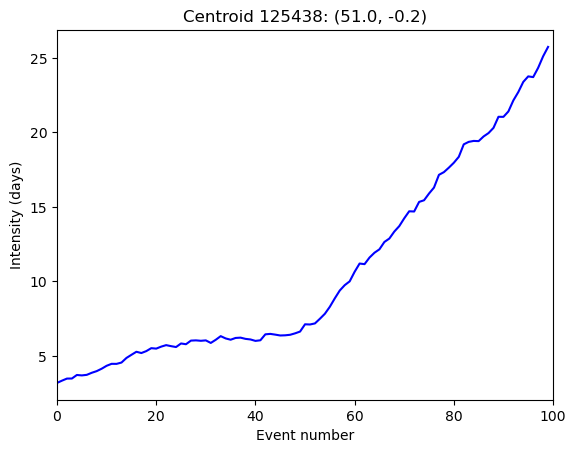

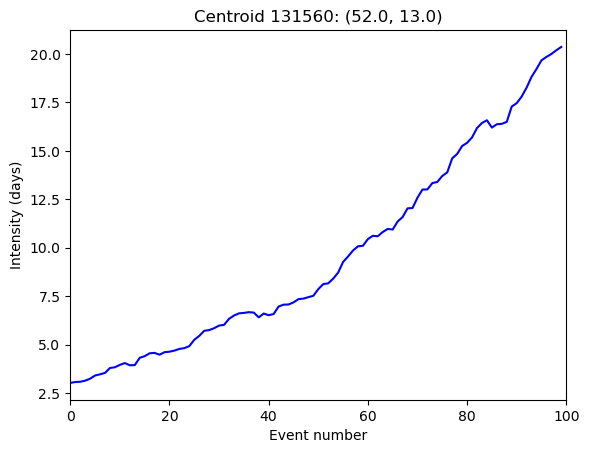

In [16]:
# 1. How many synthetic events are contained?
## Total events: estimated number of heat wave days per year. Each year is an event (100 years)
## Synthetic events: probabilistic events generated from ensemble simulations
print("1. Number of total events:", hazard.size)
print("1.1. Number of synthetic events:", np.logical_not(hazard.orig).astype(int).sum())

# 2. Identify the historical heat waves occurring between 1995 and 2001.
hist_hazard = hazard.select(date=("1995-01-01", "2001-12-31"))
print(
    "2. Number of historical events between 1995 and 2001:", len(hist_hazard.event_id)
)

# 3. Minimum, Maximum, and Shape
print("3.1. Minimum:", np.nanmin(hazard.intensity.todense()))
print("3.2. Maximum:", hazard.intensity.max())
print("3.3. Shape (columns and rows):", hazard.intensity.shape)

# Re-project to World Mercator (EPSG:4326)
# centroids.set_geometry(centroids.geometry.to_crs(epsg=4326), crs=CRS.from_epsg(4326))

# 4. Intensities of all the events in centroid closest to London at lon, lat = (-0.2, 51)
hazard.plot_intensity(centr=(-0.2, 51))

# 5. Intensities of all the events in centroid closest to Berlin at lon, lat = (13, 52)
hazard.plot_intensity(centr=(13, 52));

We can also explore and visualise the return period of the hazard under study. 

2024-09-13 21:39:34,582 - climada.hazard.base - WARNING - Return period 25.0 exceeds max. event return period.
2024-09-13 21:39:34,582 - climada.hazard.base - WARNING - Return period 50.0 exceeds max. event return period.
2024-09-13 21:39:34,582 - climada.hazard.base - WARNING - Return period 100.0 exceeds max. event return period.
2024-09-13 21:39:34,588 - climada.hazard.base - WARNING - Return period 250.0 exceeds max. event return period.


(array([[<GeoAxes: title={'center': 'Return period: 25 years'}>,
         <GeoAxes: title={'center': 'Return period: 50 years'}>],
        [<GeoAxes: title={'center': 'Return period: 100 years'}>,
         <GeoAxes: title={'center': 'Return period: 250 years'}>]],
       dtype=object),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

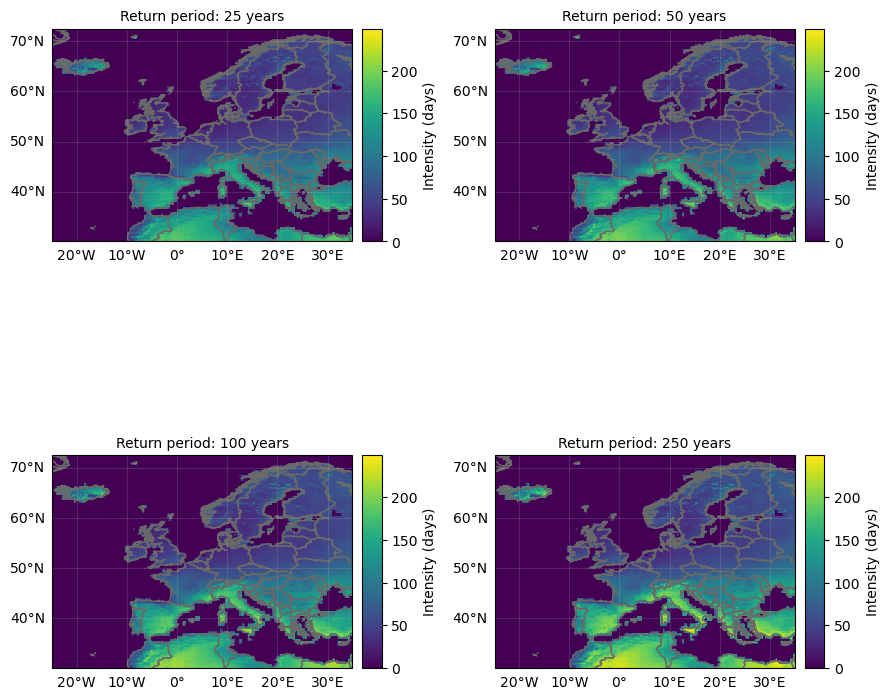

In [17]:
# Visualize return periods of different locations using the plot_rp_intensity() function
hazard.plot_rp_intensity(
    return_periods=(25, 50, 100, 250),
    smooth=True,
    axis=None,
    figsize=(9, 13),
    adapt_fontsize=True,
)

In [18]:
# A histogram can help you understand the distribution of intensity values.

# Convert the sparse matrix to a dense array
intensity_array = hazard.intensity.toarray()
print("Max intensity:", np.max(intensity_array))
print("Min intensity:", np.min(intensity_array))
print("Mean intensity:", np.mean(intensity_array))
print("Standard Deviation:", np.std(intensity_array))

plt.hist(intensity_array.flatten(), bins=50, color="c")
plt.title("Intensity Histogram")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

Max intensity: 83.17239
Min intensity: 0.0
Mean intensity: 7.345651
Standard Deviation: 12.203817


The graph below illustrates the intensification of heat waves across various locations over time.

In [19]:
# Represents the intensity of heat wave events retrieved from the dataset as an array
intensity = ds["HWD_EU_health"].values
intensity[np.isnan(intensity)] = 0  # Handle missing values (NaN) in the intensity array

# Calculate the average intensity across all locations for each event
average_intensity = intensity.mean(axis=1)

# Get the number of events
num_events = average_intensity.shape[0]

# Calculate the mean of the average intensities
mean_intensity = np.mean(average_intensity)

# Create the plot
plt.plot(range(1, num_events + 1), average_intensity, color="grey", alpha=0.3)

# Plot the mean line
plt.plot(
    range(1, num_events + 1),
    [mean_intensity] * num_events,
    color="red",
    linestyle="--",
    label="Mean",
)

# Customize the plot
plt.xlabel("Event")
plt.ylabel("Intensity")
plt.title("Hazard Intensity per Event Across Locations")
plt.legend()

# Set the x-axis tick labels
years = np.array([1985, 2005, 2025, 2045, 2065, 2085])
tick_positions = np.linspace(1, num_events, len(years))
plt.xticks(tick_positions, years)

# Show the plot
plt.show()

In [20]:
# Convert event names to years and filter for the years 1993 to 2009
years_of_interest = np.arange(1993, 2010, 1)
event_years = np.array([pd.Timestamp(event).year for event in hazard.event_name])
indices_of_interest = np.where(np.isin(event_years, years_of_interest))[0]

# Access the intensity data for the years of interest and calculate the mean
if indices_of_interest.size > 0:
    intensities = (
        hazard.intensity.toarray()[indices_of_interest, :]
        if hasattr(hazard.intensity, "toarray")
        else hazard.intensity[indices_of_interest, :]
    )
    overall_mean_heat_wave_days = np.mean(intensities)
    print(
        f"Overall mean heat wave days between 1993 and 2009: {overall_mean_heat_wave_days}"
    )
else:
    print("No events found for the years of interest.")

Overall mean heat wave days between 1993 and 2009: 2.343412160873413


## Save hazard data

We will now save the hazard data in .h5 format. Afterwards, we will retrieve and visualize it to demonstrate how to reconstruct a map from the data.

>**Tip:** For optimal performance in saving and retrieving data, we recommend using the .h5 format with CLIMADA. While multiple formats are available for saving data, the .h5 format is the most efficient.

In [21]:
# Save the hazard as.h5
filename = f"{DATADIR}/haz_heat_waves.h5"
hazard.write_hdf5(filename)

# Read the hazard
haz = Hazard.from_hdf5(filename)

<100x254575 sparse matrix of type '<class 'numpy.float32'>'
	with 11990700 stored elements in Compressed Sparse Row format>

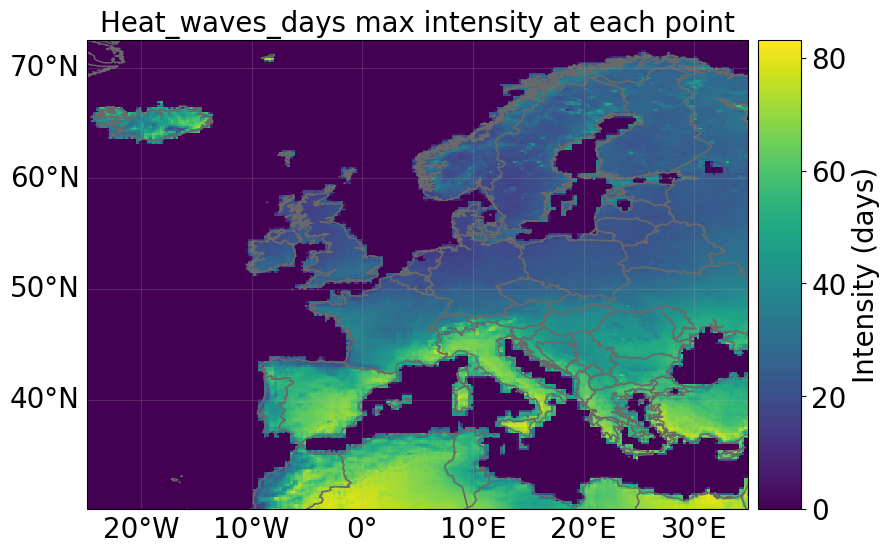

In [22]:
# Plot the hazard for event 0 from .h5
# "event = 0" refers to the maximum intensity at each point
haz.plot_intensity(event=0)
haz.intensity

## Generate and Save Hazard Maps

In this step, we will generate and save hazard maps for each year's heatwave output. To ensure a consistent and unified mapping across different time steps, we have defined a custom color map ranging from white to red. This color map will be applied consistently to all the maps generated in this analysis. The saved maps will be valuable for further analysing and examining heatwave patterns.

In [23]:
import matplotlib.colors as mcolors
import os

# Define the custom colormap for consistent and coherent mapping across time and export
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#FDF2EC", "#6A1315"])
cmap.set_under("white")

cmap = plt.get_cmap("Reds").copy()
cmap.set_under("white")

# plot the hazard intensity for every 10 events
for event in np.arange(0, 100, 10):
    # Plot the hazard for the current event
    im = haz.plot_intensity(
        event=event, cmap=cmap, vmin=0.01, vmax=90
    )  # Set the minimum and maximum values for the color ramp

    # Save the plot as a PNG file in the specified directory
    plt.savefig(os.path.join(DATADIR, f"hazard_{event}.png"))

    # Close the plot to free up resources
    plt.close()

Now that we have seen how to create, save and explore a hazard, we will create the data for the area we are interested in for further analysis. 

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

# Open the dataset
hwd_eu_rcp85_mean = f"{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc"
ds = xr.open_dataset(hwd_eu_rcp85_mean)

# Define the latitude and longitude boundaries for Germany and Switzerland combined
lat_bounds = [45.6, 55.0]  # min and max latitude
lon_bounds = [5.5, 15.0]  # min and max longitude

# Subset the data to the bounding box
ds_subset = ds.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))

# Define the file path for the new NetCDF file
output_file = f"{DATADIR}/HWD_DEU_CH_health_rcp85_mean_v1.0.nc"

# Save the subsetted dataset as a new NetCDF file
ds_subset.to_netcdf(output_file)

print(f"Dataset saved as: {output_file}")

# Plot the data
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": proj})
data_to_plot = ds_subset["HWD_EU_health"].isel(time=98)
data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Reds")
ax.coastlines()
ax.gridlines()
ax.add_feature(cfeature.BORDERS, edgecolor="black")  # Adds country borders
plt.show()

Dataset saved as: C:\Users\jimmy/Documents\test_data/HWD_DEU_CH_health_rcp85_mean_v1.0.nc


# Estimate exposure

After creating the hazard, we will proceed to create the exposure. Exposure refers to the collection of assets, individuals, infrastructure, and other elements within a specific area of interest that may be vulnerable to hazards. It encompasses their geographical coordinates, values, and other relevant information. There are two main options for obtaining exposure data:

- CLIMADA's Ready-to-Use Data: CLIMADA offers pre-existing exposure data called LitPop. LitPop combines estimates of asset value, economic activity, or population based on nightlight intensity and population count data. [Click for more information](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_LitPop.html) 

- Custom Data: If you have your own exposure data, you can provide the necessary information, such as asset values, economic activity, or population, to describe the exposed elements. [Click for more information](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_Exposures.html#Exposures-from-an-excel-file) 

Let's begin by exploring the utilization of LitPop exposure data (here, we will download data for Europe and then refine our selection to Switzerland and Germany). Subsequently, we will create our exposure data based on the WorldPop population count grid.

## Import class LitPop

### Explore LitPop data

In [25]:
from climada.util.api_client import Client

client = Client()

In [26]:
# Fetch the list of data type infos on CLIMADA

data_types = client.list_data_type_infos()
dtf = pd.DataFrame(data_types)
dtf.sort_values(["data_type_group", "data_type"])

data_type data_type_group  status  \
6                centroids       centroids  active   
4          crop_production       exposures  active   
10                   crops       exposures  active   
0                   litpop       exposures  active   
13  aqueduct_coastal_flood          hazard  active   
8               earthquake          hazard  active   
9                    flood          hazard  active   
12                    hail          hazard  active   
7       relative_cropyield          hazard  active   
3              river_flood          hazard  active   
5             storm_europe          hazard  active   
1         tropical_cyclone          hazard  active   
2                 wildfire          hazard  active   
11       hail_damage_crops          impact  active   

                                          description  \
6                                                None   
4   Historical and twenty-first century crop produ...   
10  Crop exposure for Switzerland in 2021 obtained...   
0   A global high-resolution asset exposure datase...   
13  Global probabilistic coastal flood maps for ba...   
8   Earthquake hazard sets at 150 arcsec (ca. 4km)...   
9   Flood footprint of historical events at a 200m...   
12  Radar-based daily hail hazard data at 1km spat...   
7   Historical and twenty-first century crop produ...   
3   River flood [flood depth in meters and flooded...   
5   European winter storm [gust in meters per seco...   
1   Tropical cyclone wind footprints (m/s) at 150 ...   
2   Global wildfire dataset at 4km resolution, bas...   
11  Hail damage to crops for 10-12 hail days (depe...   

                                           properties  \
6   [{'property': 'res_arcsec_land', 'mandatory': ...   
4   [{'property': 'crop', 'mandatory': True, 'desc...   
10  [{'property': 'crop', 'mandatory': True, 'desc...   
0   [{'property': 'spatial_coverage', 'mandatory':...   
13  [{'property': 'climate_scenario', 'mandatory':...   
8   [{'property': 'res_arcsec', 'mandatory': True,...   
9   [{'property': 'date_creation', 'mandatory': Tr...   
12  [{'property': 'variable', 'mandatory': True, '...   
7   [{'property': 'climate_scenario', 'mandatory':...   
3   [{'property': 'res_arcsec', 'mandatory': True,...   
5   [{'property': 'data_source', 'mandatory': Fals...   
1   [{'property': 'spatial_coverage', 'mandatory':...   
2   [{'property': 'res_arcsec', 'mandatory': True,...   
11  [{'property': 'crop', 'mandatory': True, 'desc...   

                                        key_reference  \
6                                                  []   
4   [{'ref_no': 1, 'ref_url': 'https://doi.org/10....   
10  [{'ref_no': 1, 'ref_url': 'https://doi.org/10....   
0   [{'ref_no': 1, 'ref_url': 'https://doi.org/10....   
13  [{'ref_no': 1, 'ref_url': 'https://www.wri.org...   
8   [{'ref_no': 1, 'ref_url': None, 'key_reference...   
9                                                  []   
12  [{'ref_no': 1, 'ref_url': 'https://doi.org/10....   
7   [{'ref_no': 1, 'ref_url': 'https://doi.org/10....   
3   [{'ref_no': 1, 'ref_url': 'https://www.nature....   
5   [{'ref_no': 1, 'ref_url': 'https://www.nat-haz...   
1   [{'ref_no': 1, 'ref_url': 'https://doi.org/10....   
2   [{'ref_no': 1, 'ref_url': 'https://gmd.coperni...   
11  [{'ref_no': 1, 'ref_url': 'https://doi.org/10....   

                                        version_notes  
6                                                  []  
4                                                  []  
10                                                 []  
0   [{'version': 'v2', 'notes': 'Countries with no...  
13                                                 []  
8                                                  []  
9                                                  []  
12                                                 []  
7                                                  []  
3   [{'version': 'v2', 'notes': 'Higher resolution...  
5                     

In [27]:
# Print out the available properties for the Litpop data in the CLIMADA data API
print(client.get_property_values(client.list_dataset_infos(data_type="litpop")))

{'res_arcsec': ['150'], 'exponents': ['(3,0)', '(0,1)', '(1,1)'], 'fin_mode': ['pc', 'pop'], 'spatial_coverage': ['country', 'global'], 'country_iso3alpha': ['SUR', 'SOM', 'ECU', 'ISL', 'KHM', 'FRO', 'IRL', 'ESP', 'SVN', 'DNK', 'RUS', 'LUX', 'COD', 'VGB', 'USA', 'URY', 'ALB', 'CHE', 'KEN', 'IMN', 'PRT', 'QAT', 'EST', 'DEU', 'MEX', 'MOZ', 'TCA', 'UGA', 'BRB', 'LVA', 'CZE', 'ARE', 'GNQ', 'IRQ', 'SVK', 'FJI', 'ETH', 'UZB', 'MDA', 'ZAF', 'CUB', 'NLD', 'CAF', 'HTI', 'SEN', 'GEO', 'PRI', 'JPN', 'GBR', 'ROU', 'PLW', 'ERI', 'SDN', 'MNG', 'TCD', 'LCA', 'GUY', 'IND', 'GRD', 'JEY', 'MDV', 'WSM', 'ABW', 'MUS', 'NCL', 'LSO', 'BHR', 'OMN', 'CMR', 'LBR', 'TTO', 'GMB', 'TKM', 'MSR', 'LBN', 'MNP', 'AUS', 'MCO', 'BDI', 'MLT', 'NRU', 'SYC', 'RWA', 'FRA', 'DMA', 'DZA', 'GNB', 'CIV', 'CHN', 'MAR', 'VUT', 'VCT', 'MHL', 'NAM', 'CRI', 'TWN', 'COK', 'TUR', 'SWE', 'GGY', 'SLB', 'MLI', 'TGO', 'TUN', 'BEL', 'LAO', 'BHS', 'BLR', 'NPL', 'TUV', 'AGO', 'NOR', 'VIR', 'HND', 'SSD', 'SLE', 'KGZ', 'BMU', 'MWI', 'NFK', 'B

In [28]:
# Fetch the list of LitPop dataset infos for Germany and Switzerland
litpop_datasets = client.list_dataset_infos(
    data_type="litpop", properties={"country_name": ["Germany", "Switzerland"]}
)
litpop_df = client.into_datasets_df(litpop_datasets)
litpop_df  # The 150 arcsec is app 4.631 kilometers

data_type data_type_group                                  uuid  \
0    litpop       exposures  d99916c1-343c-4826-96d6-d11987e4399f   
1    litpop       exposures  5a3e72fb-a8e0-48b5-b2ec-d6d9b845b687   
2    litpop       exposures  552ce473-953f-44db-9504-0bf078ba7cb7   
3    litpop       exposures  9203fb46-5d65-45a8-98d7-ad439463ae2b   
4    litpop       exposures  4aafe246-c3bf-4f1e-b3d4-79831abf9d91   
5    litpop       exposures  ca0b1390-0ccc-4bac-8867-c6f9c0ef7703   

                             name version  status   doi  \
0  LitPop_assets_pc_150arcsec_CHE      v3  active  None   
1  LitPop_assets_pc_150arcsec_DEU      v3  active  None   
2        LitPop_pop_150arcsec_DEU      v3  active  None   
3        LitPop_pop_150arcsec_CHE      v3  active  None   
4            LitPop_150arcsec_CHE      v3  active  None   
5            LitPop_150arcsec_DEU      v3  active  None   

                                         description  \
0  LitPop asset value exposure per country: Gridd...   
1  LitPop asset value exposure per country: Gridd...   
2  LitPop population exposure per country: Gridde...   
3  LitPop population exposure per country: Gridde...   
4  LitPop asset value exposure per country: Gridd...   
5  LitPop asset value exposure per country: Gridd...   

                                     license  \
0  Attribution 4.0 International (CC-BY-4.0)   
1  Attribution 4.0 International (CC-BY-4.0)   
2  Attribution 4.0 International (CC-BY-4.0)   
3  Attribution 4.0 International (CC-BY-4.0)   
4  Attribution 4.0 International (CC-BY-4.0)   
5  Attribution 4.0 International (CC-BY-4.0)   

                    activation_date expiration_date res_arcsec exponents  \
0  2024-06-07 08:21:45.678322+00:00            None        150     (3,0)   
1  2024-06-07 08:21:45.775654+00:00            None        150     (3,0)   
2  2024-06-07 08:21:51.998009+00:00            None        150     (0,1)   
3  2024-06-07 08:21:52.088193+00:00            None        150     (0,1)   
4  2024-06-07 08:21:55.124056+00:00            None        150     (1,1)   
5  2024-06-07 08:21:55.563907+00:00            None        150     (1,1)   

  fin_mode spatial_coverage  climada_version date_creation country_iso3alpha  \
0       pc          country  v4.1.1 (v3.1.2)     2022-6-30               CHE   
1       pc          country  v4.1.1 (v3.1.2)     2022-6-30               DEU   
2      pop          country  v4.1.1 (v3.1.2)     2022-6-30               DEU   
3      pop          country  v4.1.1 (v3.1.2)     2022-6-30               CHE   
4       pc          country  v4.1.1 (v3.1.2)     2022-6-26               CHE   
5       pc          country  v4.1.1 (v3.1.2)     2022-6-26               DEU   

  country_name country_iso3num  
0  Switzerland             756  
1      Germany             276  
2      Germany             276  
3  Switzerland             756  
4  Switzerland             756  
5      Germany             276

### Visualize Exposures LitPop

We will now turn our attention to the LitPop data for this demonstration. But first, there are a few points to mention:
- You can provide either a single country or a list of countries.
- Load a default LitPop exposure entity for Switzerland and Germany in 2018 (ISO3-Codes 'CHE' and 'DEU').
- To incorporate all EU countries, you should add each of them like: ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE'].
- The default mode provides information on USD assets, while *fin_mode='pop'* provides information on population counts.
- To determine the weight between GDP and population in the LitPop operation, you can use, for instance, exponents=(0,1). This results in the formula for creating the LitPop asset distribution: LitPop = GDP^0 * Population^1.

>**Tip:** The LitPop population data is based on gridded night lights from NASA at a 0.5 km resolution and gridded population data from CIESIN at a 1 km resolution. Therefore, LitPop can be retrieved at a maximum resolution of 0.5 km. Set with *"res_arcsec"*. [More information](https://essd.copernicus.org/articles/12/817/2020/)

In [29]:
from climada.util.api_client import Client
from climada.entity import LitPop
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# Initialize the client
client = Client()

# Fetch the list of LitPop dataset info for Germany and Switzerland
litpop_datasets = client.list_dataset_infos(
    data_type="litpop", properties={"country_name": ["Germany", "Switzerland"]}
)

# Convert dataset infos to a DataFrame
litpop_df = client.into_datasets_df(litpop_datasets)
print(litpop_df)

# Download the data for Germany and Switzerland using the client
file_path_germany = client.get_dataset_file(
    data_type="litpop",
    properties={
        "country_name": "Germany",
        "res_arcsec": "150",
        "fin_mode": "pop",
        "exponents": "(0,1)",
    },
)

file_path_switzerland = client.get_dataset_file(
    data_type="litpop",
    properties={
        "country_name": "Switzerland",
        "res_arcsec": "150",
        "fin_mode": "pop",
        "exponents": "(0,1)",
    },
)

# Initialize LitPop exposures from the downloaded files
try:
    exposure_germany = LitPop.from_hdf5(file_path_germany)
    exposure_switzerland = LitPop.from_hdf5(file_path_switzerland)
except FileNotFoundError as err:
    print(
        "Reason for error: The GPW population data has not been downloaded, c.f. section 'Input data' above."
    )
    raise err

# Combine exposures for Germany and Switzerland
combined_gdf = gpd.GeoDataFrame(
    pd.concat([exposure_germany.gdf, exposure_switzerland.gdf], ignore_index=True)
)

# Create a new LitPop object with the combined data
exposure = LitPop()
exposure.gdf = combined_gdf
exposure.set_geometry_points()  # Ensure geometries are correctly set

# Plot using exposure_combined.plot_scatter()
plot = exposure.plot_scatter(label="Population")

# Get the current axis
ax = plt.gca()

# Modify the size of axis labels
fontsize_val = 12
plt.xticks(fontsize=fontsize_val)
plt.yticks(fontsize=fontsize_val)

# Set y-ticks and their labels to represent values in thousands
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels([f"{ytick/1000:.1f}k" for ytick in yticks], clip_on=True)

# Set the y-axis label
plt.ylabel("Population counts")

plt.tight_layout()

# Show the plot
plt.show()

  data_type data_type_group                                  uuid  \
0    litpop       exposures  d99916c1-343c-4826-96d6-d11987e4399f   
1    litpop       exposures  5a3e72fb-a8e0-48b5-b2ec-d6d9b845b687   
2    litpop       exposures  552ce473-953f-44db-9504-0bf078ba7cb7   
3    litpop       exposures  9203fb46-5d65-45a8-98d7-ad439463ae2b   
4    litpop       exposures  4aafe246-c3bf-4f1e-b3d4-79831abf9d91   
5    litpop       exposures  ca0b1390-0ccc-4bac-8867-c6f9c0ef7703   

                             name version  status   doi  \
0  LitPop_assets_pc_150arcsec_CHE      v3  active  None   
1  LitPop_assets_pc_150arcsec_DEU      v3  active  None   
2        LitPop_pop_150arcsec_DEU      v3  active  None   
3        LitPop_pop_150arcsec_CHE      v3  active  None   
4            LitPop_150arcsec_CHE      v3  active  None   
5            LitPop_150arcsec_DEU      v3  active  None   

                                         description  \
0  LitPop asset value exposure per country: Gr

In [30]:
# Visualize table of exposures LitPop
exposure.gdf.head()

value                  geometry   latitude  longitude  region_id  \
0  1051.009840  POINT (6.68750 53.60417)  53.604167   6.687500        276   
1  1160.293252  POINT (6.72917 53.60417)  53.604167   6.729167        276   
2   777.166514  POINT (6.77083 53.60417)  53.604167   6.770833        276   
3    27.639763  POINT (6.97917 53.68750)  53.687500   6.979167        276   
4     9.651074  POINT (7.02083 53.68750)  53.687500   7.020833        276   

   impf_  
0      1  
1      1  
2      1  
3      1  
4      1

In [31]:
# Print exposure shape
print(exposure.gdf.shape)  # 29264 rows and 6 columns

(29264, 6)


In [32]:
# Calculate the total population for each country
switzerland_population = round(
    exposure.gdf.loc[exposure.gdf["region_id"] == 756, "value"].sum()
)
germany_population = round(
    exposure.gdf.loc[exposure.gdf["region_id"] == 276, "value"].sum()
)
total_population = switzerland_population + germany_population

# Print the population count for Switzerland and Germany
print("Population in Switzerland:", "{:,}".format(switzerland_population))
print("Population in Germany:", "{:,}".format(germany_population))
print("Total Population:", "{:,}".format(total_population))

Population in Switzerland: 8,721,857
Population in Germany: 78,437,151
Total Population: 87,159,008


## Import own raster exposure from Worldpop (Total population counts)

Let's create our own exposure data by downloading population data for Switzerland and Germany at 1 km resolution for 2020 from Worldpop. We will then combine the data for both countries to create a single exposure mosaic.

Here are the steps to follow:

1. Download the population data:
- Visit the Worldpop website [worldpop.org](https://www.worldpop.org) or the specific data repository where the population data is available.
- Search and download the population data for Switzerland and Germany at 1 km resolution for 2020.
- Make sure to download the data in a format compatible with your analysis or processing requirements (e.g. raster file format).
2. Merge the data to create a single exposure mosaic:
- Use programming libraries such as GDAL or Rasterio to merge the population data for Switzerland and Germany into a single raster mosaic.
- The merging process should align the data correctly, considering their spatial resolution and coordinate system.


In [33]:
from climada.entity import Exposures

In [34]:
# Access and store Swiss population data
import urllib.request

url = "ftp://ftp.worldpop.org.uk/GIS/Population/Global_2000_2020_1km_UNadj/2020/CHE/che_ppp_2020_1km_Aggregated_UNadj.tif"
filename = "che_ppp_2020_1km_Aggregated_UNadj.tif"
file_path = os.path.join(
    DATADIR, filename
)  # Full file path within the DATADIR directory

try:
    urllib.request.urlretrieve(url, file_path)
    print("Download completed successfully.")
except Exception as e:
    print("An error occurred while downloading the file:", e)

Download completed successfully.


In [35]:
# Access and store Germany population data
url = "ftp://ftp.worldpop.org.uk/GIS/Population/Global_2000_2020_1km_UNadj/2020/DEU/deu_ppp_2020_1km_Aggregated_UNadj.tif"
filename = "deu_ppp_2020_1km_Aggregated_UNadj.tif"
file_path = os.path.join(
    DATADIR, filename
)  # Full file path within the DATADIR directory

try:
    urllib.request.urlretrieve(url, file_path)
    print("Download completed successfully.")
except Exception as e:
    print("An error occurred while downloading the file:", e)

Download completed successfully.


In [36]:
raster_DEU = f"{DATADIR}/deu_ppp_2020_1km_Aggregated_UNadj.tif"
raster_CHE = f"{DATADIR}/che_ppp_2020_1km_Aggregated_UNadj.tif"

In [37]:
# Read the raster data and create the Exposures instance for each country
exp_raster_DEU = Exposures.from_raster(raster_DEU)
exp_raster_CHE = Exposures.from_raster(raster_CHE)
exp_raster_DEU.check()
exp_raster_CHE.check()

### Explore exposure data for each country

In [38]:
print("Meta:", exp_raster_DEU.meta)
print("Meta:", exp_raster_CHE.meta)

Meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99999.0, 'width': 1100, 'height': 934, 'count': 1, 'transform': Affine(0.0083333333, 0.0, 5.873749977152784,
       0.0, -0.0083333333, 55.05791662990384), 'crs': CRS.from_epsg(4326)}
Meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99999.0, 'width': 544, 'height': 239, 'count': 1, 'transform': Affine(0.0083333333, 0.0, 5.957083310162034,
       0.0, -0.0083333333, 47.81624999573185), 'crs': CRS.from_epsg(4326)}


In [39]:
print("\n" + "\x1b[1;03;30;30m" + "exp_raster looks like:" + "\x1b[0m")
print(exp_raster_DEU.gdf.head())


exp_raster looks like:
   longitude  latitude  value  impf_
0   5.877917  55.05375    0.0      1
1   5.886250  55.05375    0.0      1
2   5.894583  55.05375    0.0      1
3   5.902917  55.05375    0.0      1
4   5.911250  55.05375    0.0      1


In [40]:
# Calculate the total population for each country
switzerland_population = round(exp_raster_CHE.gdf["value"].sum())
germany_population = round(exp_raster_DEU.gdf["value"].sum())
total_population = switzerland_population + germany_population

# Print the population count for Switzerland and Germany
print("Population in Switzerland:", "{:,}".format(switzerland_population))
print("Population in Germany:", "{:,}".format(germany_population))
print("Total Population:", "{:,}".format(total_population))

Population in Switzerland: 8,654,617
Population in Germany: 83,783,984
Total Population: 92,438,601


### Create a mosaic and explore the exposure data for the study area

We can create a mosaic to have the exposed population of the study area as a whole, which is more efficient for analysis. 

In [41]:
# Generating Exposure Mosaic
from osgeo import gdal
from osgeo_utils import gdal_merge

# Set the paths to the input rasters
raster_DEU = f"{DATADIR}/deu_ppp_2020_1km_Aggregated_UNadj.tif"
raster_CHE = f"{DATADIR}/che_ppp_2020_1km_Aggregated_UNadj.tif"

# set the path to the output mosaic raster
output_raster = f"{DATADIR}/mosaic.tif"

# create the gdal_merge command as a list of strings
gdal_merge_cmd = [
    "",
    "-o",
    output_raster,  # the output mosaic raster
    "-of",
    "GTiff",  # the output format (GeoTIFF)
    raster_DEU,
    raster_CHE,  # the input rasters to be merged
]

# call gdal_merge
gdal_merge.main(gdal_merge_cmd)

exp_worldpop = Exposures.from_raster(output_raster)

# Method assigns the centroids of hazard events to the exposure data.
# This step allows for associating hazard events with specific population locations.
exp_worldpop.assign_centroids(hazard)

exp_worldpop.check()

print("Meta:", exp_worldpop.meta)
print(type(exp_worldpop))
print("\n" + "\x1b[1;03;30;30m" + "exp_raster looks like:" + "\x1b[0m")
print(exp_worldpop.gdf.head())

# Print exposure shape
print(exp_worldpop.gdf.shape)

# Calculate the total population for each country
total_population = exp_worldpop.gdf["value"].sum()

# Print the population count for Switzerland and Germany
print("Population in Switzerland:", "{:,}".format(switzerland_population))
print("Population in Germany:", "{:,}".format(germany_population))
print("Total Population:", "{:,}".format(total_population))

Meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1100, 'height': 1108, 'count': 1, 'transform': Affine(0.0083333333, 0.0, 5.873749977152784,
       0.0, -0.0083333333, 55.05791662990384), 'crs': CRS.from_epsg(4326)}
<class 'climada.entity.exposures.base.Exposures'>

exp_raster looks like:
   longitude  latitude  value  centr_Heat_waves_days  impf_
0   5.877917  55.05375    0.0                 150058      1
1   5.886250  55.05375    0.0                 150058      1
2   5.894583  55.05375    0.0                 150058      1
3   5.902917  55.05375    0.0                 150058      1
4   5.911250  55.05375    0.0                 150058      1
(1218800, 5)
Population in Switzerland: 8,654,617
Population in Germany: 83,783,984
Total Population: 92,438,600.0


### Visualize exposures Worldpop

In [42]:
from climada.entity import Exposures

# Plot the exp_raster using the plot_hexbin method
print("\x1b[1;03;30;30m" + "Plotting exp_raster." + "\x1b[0m")
axs = exp_worldpop.plot_hexbin()
plt.ylabel("Population counts")

Plotting exp_raster.


Text(913.4027777777777, 0.5, 'Population counts')

# Set up vulnerability and calculate damages

We will now explore the impact of heat waves on the population. To do this, we will utilize hazard data spanning 100 years (from 1986 to 2085) and population data from LitPop. For this exercise, we will keep the exposure static, using only the population data from 2020. In subsequent exercises, we will incorporate future population scenarios.

Through impact estimation, we will generate a variety of statistics and graphs. You will learn to calculate, create, and save these for further research.

The first step involves constructing an impact matrix with all the relevant parameters for a comprehensive impact assessment. This matrix will serve as a central repository for data, facilitating in-depth analysis and evaluation. Once the matrix is created, we will ensure accessibility by saving it in all formats currently supported by CLIMADA.

In parallel, we will produce a series of maps that depict the impact of heat waves at various time points within the 100 years under study. These maps will offer insights into both the spatial distribution of impact and temporal trends. To maintain the integrity and compatibility of this mapping data, we will save it in all geospatial formats supported by CLIMADA, allowing you to browse and select the format that best suits your needs.

## Creating an impact function

Here, we create a "dummy" impact function to examine the interaction of heat waves in LitPop. The impact function is created using the previously generated hazard and exposure datasets.

The impact function is crafted, incorporating the following key elements, [click for more information](https://climada-python.readthedocs.io/en/latest/tutorial/climada_engine_Impact.html):

* Intensity: This array represents the intensity levels of the hazard. It is created using the np.linspace function, which generates a sequence of evenly spaced values between the specified start (0) and end (10) points. In this case, the array contains 100 intensity levels ranging from 0 to 10.

* MDD: This array represents the Mean Degree of Damage (MDD) values associated with the hazard intensity levels. Similar to intensity, it is created using np.linspace to generate 100 evenly spaced values between 0 and 10.

* PAA: This array represents the Proportion of Assets Affected (PAA) values associated with the hazard intensity levels. In this case, paa is initialized with ones, resulting in an array of the same size as intensity with all elements set to 1. This suggests a 100% probability of avoiding or mitigating the impact at each intensity level.

* impf_dum: An ImpactFunc object is instantiated with the parameters, including the hazard type, hazard ID, intensity, MDD, PAA, and units for intensity and MDD. The impact function is labelled as "dummy".

* impact_func_set: An ImpactFuncSet object is created, representing a collection or set of impact functions. The impf_dum impact function is added to this set using the ImpactFuncSet constructor with [impf_dum] as the argument.

* impf_ras.check(): This line of code calls the check() method on the impf_ras impact function set. 


<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;Important: The dummy function used in this documentation allows for the analysis of the relationship between exposure and the hazard. This function and parameters serves as a demonstration only; you should define your own functions according to your specific field of study.
</div>

<Axes: title={'center': 'Heat_waves_days 1: Heat wave impact function'}, xlabel='Intensity (days)', ylabel='Impact (%)'>

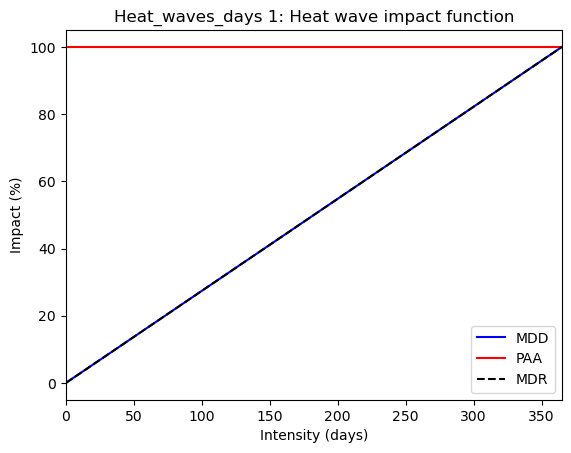

In [43]:
# Remember the libraries needed for this process
from climada.hazard import Hazard, Centroids
from scipy.sparse import csr_matrix
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
from climada.entity import LitPop
from climada.util.constants import ONE_LAT_KM
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


# Create hazard
hazard = Hazard.from_xarray_raster_file(
    f"{DATADIR}/HWD_DEU_CH_health_rcp85_mean_v1.0.nc",
    hazard_type="Heat_waves_days",
    intensity_unit="days",
    intensity="HWD_EU_health",
    coordinate_vars=dict(event="time", longitude="lon", latitude="lat"),
)

hazard.event_name = list(map(lambda x: pd.Timestamp(x).isoformat(), hazard.event_name))

# Calculate the mean number of heatwave days for each event across all cells
mean_heatwave_days_per_event = np.mean(hazard.intensity.toarray(), axis=1)

# Normalize these means to get relative frequencies for each event
# This assumes that the event with the most heatwave days is the most frequent
relative_frequencies = mean_heatwave_days_per_event / np.sum(
    mean_heatwave_days_per_event
)

# Assign these relative frequencies to the hazard object's frequency attribute
hazard.frequency = relative_frequencies

# Load a default LitPop exposure entity for Switzerland and Germany:
# Fetch the list of LitPop dataset info for Germany and Switzerland
litpop_datasets = client.list_dataset_infos(
    data_type="litpop", properties={"country_name": ["Germany", "Switzerland"]}
)

# Convert dataset infos to a DataFrame
litpop_df = client.into_datasets_df(litpop_datasets)

# Download the data for Germany and Switzerland using the client
file_path_germany = client.get_dataset_file(
    data_type="litpop",
    properties={"country_name": "Germany", "fin_mode": "pop", "exponents": "(0,1)"},
)

file_path_switzerland = client.get_dataset_file(
    data_type="litpop",
    properties={"country_name": "Switzerland", "fin_mode": "pop", "exponents": "(0,1)"},
)

# Initialize LitPop exposures from the downloaded files
try:
    exposure_germany = LitPop.from_hdf5(file_path_germany)
    exposure_switzerland = LitPop.from_hdf5(file_path_switzerland)
except FileNotFoundError as err:
    print(
        "Reason for error: The GPW population data has not been downloaded, c.f. section 'Input data' above."
    )
    raise err

# Combine exposures for Germany and Switzerland
combined_gdf = gpd.GeoDataFrame(
    pd.concat([exposure_germany.gdf, exposure_switzerland.gdf], ignore_index=True)
)

# Create a new LitPop object with the combined data
exposure = LitPop()
exposure.gdf = combined_gdf
exposure.set_geometry_points()  # Ensure geometries are correctly set

# Method assigns the centroids of hazard events to the exposure data. This step allows for the association of hazard events with specific population locations.
exposure.assign_centroids(hazard)


# Define the impact function
if_set = ImpactFuncSet()
if_heatwave = ImpactFunc()
if_heatwave.haz_type = "Heat_waves_days"
if_heatwave.id = 1
if_heatwave.name = "Heat wave impact function"
if_heatwave.intensity_unit = "days"
if_heatwave.intensity = np.arange(
    0, 366, 1
)  # Considering the maximum number of heat wave days in a year is 365
if_heatwave.mdd = np.linspace(
    0, 1, 366
)  # Linearly increasing mean damage degree from 0 to 1
if_heatwave.paa = np.ones(
    366
)  # Considering 100% of assets are affected for any number of heat wave days
if_set.append(if_heatwave)

# Plot the impact function
if_heatwave.plot()

### Explore Impact funtion data

In [44]:
# Calculate the mdr at hazard intensity 84 days
print("Mean damage ratio at intensity 84 days: ", if_heatwave.calc_mdr(84))

Mean damage ratio at intensity 84 days:  0.23013698630136986


In [45]:
from scipy.interpolate import interp1d

# Create an interpolation function based on the intensity and paa values
interp_func = interp1d(if_heatwave.intensity, if_heatwave.paa)

# Use the interpolation function to get the paa value at intensity 0
paa_at_0 = interp_func(5)

print("Percentage of affected population at intensity 17 days: ", paa_at_0 * 100, "%")

Percentage of affected population at intensity 17 days:  100.0 %


## Calculate impact

In the context of hazard impact assessment, we have computed several attributes that provide valuable information about the impacts of hazards on different locations. After calling `ImpactCalc(Exposure, ImpactFuncSet, Hazard).impact(save_mat=False)`, the folllowing attributes are calculated. Let's understand each attribute:

- at_event: This attribute is a numpy array that represents the impact for each hazard event, where the impact is calculated by summing the impacts at each location. It provides a comprehensive view of the impact caused by each individual event.

- eai_exp: The expected annual impact for each location is represented by this numpy array. It considers the impacts from all-hazard events, weighted by their respective frequencies. By summing the impacts over all events at each location, we obtain the total expected annual impact.

- aai_agg: This attribute is a single float value representing the total annual average aggregated impact. It is calculated by summing the impacts over all events and locations, providing a measure of the overall impact of hazards on the exposed areas.

- impt_mat: The impact matrix is a sparse CSR matrix. It has the hazard events as rows and the exposure points (locations) as columns. The matrix has dimensions of `num_events x num_exp`. If the save_mat parameter was set to True during the impact calculation, the matrix contains the impact values for each event and exposure point. Otherwise, it remains empty.

- tot_value: The total exposure value affected is a single float value representing the sum of values for all exposure locations affected by at least one hazard event. It provides an estimate of the overall value at risk due to the impacts of hazards.

These computed attributes provide valuable insights into the impacts of hazards, allowing us to understand the severity and distribution of impacts across events and locations. They facilitate decision-making processes and help prioritize mitigation and adaptation measures to minimize the potential consequences of future hazard events.

In [46]:
# Calculate the impact
from climada.engine import ImpactCalc

heat_waves_impact = ImpactCalc(exposure, if_set, hazard).impact(save_mat=True)
filename = f"{DATADIR}/impact_output.xlsx"
heat_waves_impact.write_excel(filename)  # Write the impact to an Excel file

In [47]:
# Get the hazard type and hazard id
[haz_type] = if_set.get_hazard_types()
[haz_id] = if_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

# Exposures: rename column and assign ID
hazard_type = "Heat_waves_days"

if "impf_" in exposure.gdf.columns:
    exposure.gdf.rename(columns={"impf_": "impf_" + hazard_type}, inplace=True)
exposure.gdf["impf_" + hazard_type] = haz_id

exposure.gdf.head()  # Visualize exposure as df

hazard type: Heat_waves_days, hazard id: 1


value                  geometry   latitude  longitude  region_id  \
0  1051.009840  POINT (6.68750 53.60417)  53.604167   6.687500        276   
1  1160.293252  POINT (6.72917 53.60417)  53.604167   6.729167        276   
2   777.166514  POINT (6.77083 53.60417)  53.604167   6.770833        276   
3    27.639763  POINT (6.97917 53.68750)  53.687500   6.979167        276   
4     9.651074  POINT (7.02083 53.68750)  53.687500   7.020833        276   

   impf_Heat_waves_days  centr_Heat_waves_days  
0                     1                   7692  
1                     1                   7692  
2                     1                   7693  
3                     1                   7791  
4                     1                   7791

### Explore Impact data

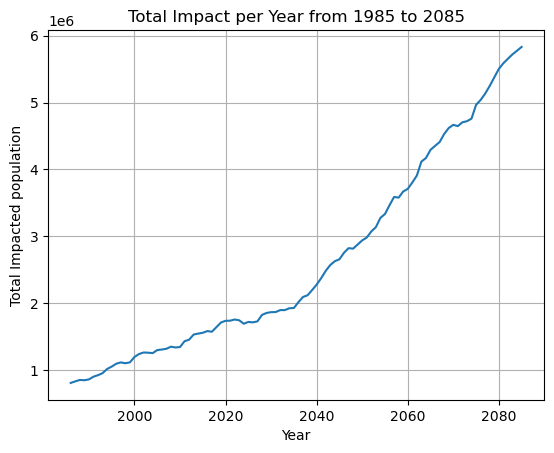

In [48]:
# Plot the total impact per year
years = np.array([datetime.fromordinal(date).year for date in hazard.date])
unique_years = np.unique(years)
annual_impact = np.zeros(unique_years.shape)
for i, year in enumerate(unique_years):
    annual_impact[i] = heat_waves_impact.at_event[years == year].sum()
plt.plot(unique_years, annual_impact)
plt.xlabel("Year")
plt.ylabel("Total Impacted population")
plt.title("Total Impact per Year from 1985 to 2085")
plt.grid(True)
plt.show()

In [49]:
# Annual impact total estimate
# Here the "calc_impact_year_set" can be used
annual_impacts = heat_waves_impact.calc_impact_year_set()

# Print annual impacts
for year, impact_value in annual_impacts.items():
    impact_value_int = int(impact_value)
    print(f"Year: {year}, Impact: {impact_value_int:,}")

2024-09-13 21:47:19,864 - climada.engine.impact - WARNING - The use of Impact.calc_impact_year_set is deprecated.Use Impact.impact_per_year instead.
Year: 1986, Impact: 812,966
Year: 1987, Impact: 835,951
Year: 1988, Impact: 857,348
Year: 1989, Impact: 853,039
Year: 1990, Impact: 865,349
Year: 1991, Impact: 906,088
Year: 1992, Impact: 928,760
Year: 1993, Impact: 958,914
Year: 1994, Impact: 1,021,642
Year: 1995, Impact: 1,056,542
Year: 1996, Impact: 1,099,670
Year: 1997, Impact: 1,119,049
Year: 1998, Impact: 1,106,924
Year: 1999, Impact: 1,119,944
Year: 2000, Impact: 1,200,308
Year: 2001, Impact: 1,244,321
Year: 2002, Impact: 1,267,271
Year: 2003, Impact: 1,264,453
Year: 2004, Impact: 1,258,097
Year: 2005, Impact: 1,303,209
Year: 2006, Impact: 1,311,571
Year: 2007, Impact: 1,322,853
Year: 2008, Impact: 1,353,888
Year: 2009, Impact: 1,342,378
Year: 2010, Impact: 1,348,894
Year: 2011, Impact: 1,435,574
Year: 2012, Impact: 1,458,824
Year: 2013, Impact: 1,535,736
Year: 2014, Impact: 1,549,2

In [50]:
# Access the impact attributes
print("Shape of heat_waves_impact.at_event:", heat_waves_impact.at_event.shape)
print("Shape of hazard intensity:", hazard.intensity.shape)
print("Number of centroids in exposure:", len(exposure.gdf))
print("Impact attributes:")
print(" - coord_exp:", heat_waves_impact.coord_exp)
print(" - frequency_unit:", heat_waves_impact.frequency_unit)
print(" - unit:", heat_waves_impact.unit)
print(" - at_event:", heat_waves_impact.at_event)
print(" - eai_exp:", heat_waves_impact.eai_exp)
print(
    " - aai_agg:", heat_waves_impact.aai_agg
)  # In the case of the heat waves this atribute is not relevant since we have agregated heat waves per year
print(" - tot_value:", heat_waves_impact.tot_value)

Shape of heat_waves_impact.at_event: (100,)
Shape of hazard intensity: (100, 9120)
Number of centroids in exposure: 29264
Impact attributes:
 - coord_exp: [[53.60416667  6.6875    ]
 [53.60416667  6.72916667]
 [53.60416667  6.77083333]
 ...
 [45.85416667  8.9375    ]
 [45.85416667  8.97916667]
 [45.85416667  9.02083333]]
 - frequency_unit: 1/year
 - unit: USD
 - at_event: [ 812966.58205962  835951.86487428  857348.82065507  853039.17926255
  865349.42662085  906088.80238552  928760.22039679  958914.99451054
 1021642.03359289 1056542.81984992 1099670.76982154 1119049.66021354
 1106924.89411082 1119944.14167172 1200308.06238645 1244321.85088453
 1267271.31855612 1264453.61581506 1258097.56932315 1303209.48502192
 1311571.25385325 1322853.51064667 1353888.22297524 1342378.16532836
 1348894.77399706 1435574.8275676  1458824.48884467 1535736.93024595
 1549235.99439076 1561604.09746148 1586959.27858754 1577484.51585269
 1646301.82801795 1715322.07898109 1740403.5441704  1741984.60825925
 175

We will now calculate the **aggregated annual average impact (AAI)**. This is the average annual impact, aggregated over all exposure points and the entire study period, in this case, the 100 years between 1985 and 2085. Essentially, it is the total impact over the study period divided by the number of years in the study period.

Throughout the 100-year study, it can be observed that the average population could be affected per year is around 3,500,000 people. This is due to the fact that individuals are affected by multiple heatwaves in the same year at certain points.

In [51]:
# Calculate the aggregated average annual impact
aai_agg = int(heat_waves_impact.aai_agg)
print("Aggregated average annual impact:", "{:,}".format(aai_agg))

Aggregated average annual impact: 3,537,142


Calculate **Annual Expected Impact (EAI)** for the year 2020 and 2085 

In [52]:
# Access the event for the target years
event_2020 = years.tolist().index(2020)  # index of the event for the year 2020
event_2085 = years.tolist().index(2085)  # index of the event for the year 2085

# Calculate the total impact for the target years
impact_2020 = round(heat_waves_impact.at_event[event_2020])
impact_2085 = round(heat_waves_impact.at_event[event_2085])

# Calculate the expected annual impact for the target years 2020 and 2085
# Since there's only one event for the year 1985, the EAI is the same as the total impact
eai_2020 = impact_2020
eai_2085 = impact_2085
print(f"Expected annual impact for the year 2020: {eai_2020:,} people")
print(f"Expected annual impact for the year 2085: {eai_2085:,} people")

Expected annual impact for the year 2020: 1,740,404 people
Expected annual impact for the year 2085: 5,829,953 people


From section 4.1.2, "Visualize Exposures LitPop", it is indicated that the combined population of Switzerland and Germany used as the reference population, was 87,159,008 individuals. Now, we will compute the proportion of this affected reference population.

In [53]:
# Calculate the percentage change for the year 2020
percentage_change_2020 = (eai_2020 / total_population) * 100
print(
    f"Percentage change for the year 2020: {percentage_change_2020:.1f}%. \nThis figure indicates that not all of the population is at risk in 2020."
)

Percentage change for the year 2020: 1.9%. 
This figure indicates that not all of the population is at risk in 2020.


The **Frequency Curve** below shows the annual probability (frequency) of overshooting a given impact level. It is calculated by sorting the impacts of all events in descending order and plotting them against their rank divided by the 100 years under study. In CLIMADA, you can calculate the exceedance frequency curve using the calc_freq_curve method of the Impact object. 

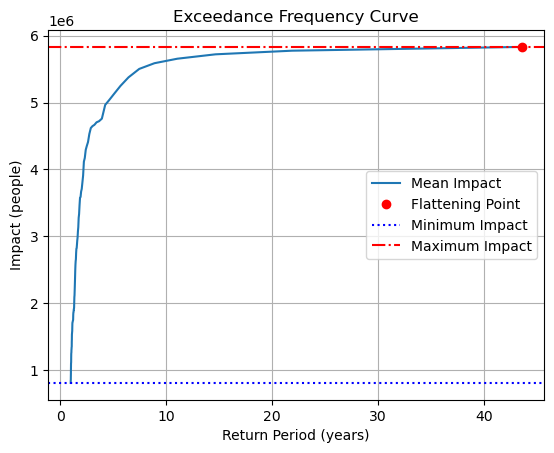

In [54]:
# Compute the exceedance frequency curve
freq_curve = heat_waves_impact.calc_freq_curve()
impact_derivative = np.gradient(freq_curve.impact, freq_curve.return_per)
flat_threshold = np.std(impact_derivative) * 0.0015
flat_indices = np.where(np.abs(impact_derivative) < flat_threshold)[0]

# Find the minimum and maximum impact values
min_impact = np.min(freq_curve.impact)
max_impact = np.max(freq_curve.impact)

# Properties
fig, ax = plt.subplots()
ax.plot(freq_curve.return_per, freq_curve.impact, label="Mean Impact")
if flat_indices.size > 0:
    flat_index = flat_indices[0]
    flat_return_period = freq_curve.return_per[flat_index]
    flat_impact = freq_curve.impact[flat_index]
    ax.plot(flat_return_period, flat_impact, "ro", label="Flattening Point")
else:
    print("No flattening point found based on the threshold.")

ax.axhline(min_impact, color="blue", linestyle=":", label="Minimum Impact")
ax.axhline(max_impact, color="red", linestyle="-.", label="Maximum Impact")
ax.set_title("Exceedance Frequency Curve")
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Impact (people)")
ax.grid(True)
ax.legend()
plt.show()

### Visualize Impact 

We will visualise the impact through **Expected Annual Impact (EAI)**. EAI is the expected impact **in an average year, for each exposure point**, based on data from the 100 years under study. It is the sum of the impacts of all events, each multiplied by its frequency (the number of times it occurs per year), divided by the number of years in the study period. This metric is beneficial when seeking an overview of the average impact over time, offering a broader perspective that highlights areas more consistently affected by the hazard in question.

Below, we present different outputs to showcase the results:

**plot_hexbin_eai_exposure():**

Hexbin: This method employs hexagonal binning for visualization. Hex binning divides a map into hexagonal intervals, aggregating the data within each interval. Each hexagon's color represents the aggregated value of the data it contains. This approach is beneficial for visualizing data in areas with a high density of data points, as it prevents overplotting and highlights patterns more effectively.

**plot_raster_eai_exposure():**

Raster: In geospatial analysis, a raster is a fundamental data format based on resizable grids where each cell or pixel holds a value. In this visualization, each cell is colored based on the average population affected by heat waves. The results are displayed on a logarithmic scale.

These plots can be modified according to the user's needs. For more information, please refer to the following [documentation](https://climada-python.readthedocs.io/en/v5.0.0/climada/climada.engine.html#climada.engine.impact.Impact.plot_hexbin_eai_exposure).

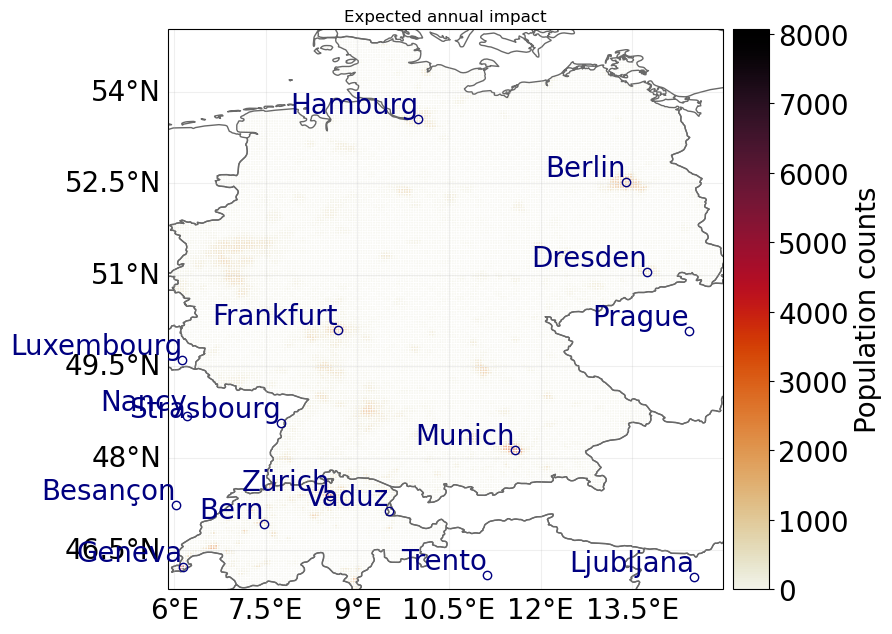

In [55]:
# Plot the expected annual impact (EAI) with plot_hexbin_eai_exposure

eai_heat_waves_impact = heat_waves_impact.plot_hexbin_eai_exposure(adapt_fontsize=True)

# Save the plot as an image
filename = f"{DATADIR}/eai_heat_waves_impact_hexbin.png"
plt.ylabel("Population counts")
plt.savefig(filename, dpi=800, bbox_inches="tight")

In [56]:
# Plot the expected annual impact (EAI) with plot_raster_eai_exposure()

heat_waves_impact.plot_raster_eai_exposure()

# Save the plot as an image
filename = f"{DATADIR}/eai_heat_waves_impact_raster.png"
plt.ylabel("Population counts (log10)")
plt.savefig(filename, dpi=300, bbox_inches="tight")

c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2672: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(
c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2415: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')

Another visualization tool available is the **plot_basemap_impact_exposure()** function. It offers a geographical depiction of both the impact of a hazard event and the exposure of various assets or populations to that event. This map allows users to quickly identify areas of high impact and high exposure, which are essential for making informed decisions in climate adaptation and risk management. It is instrumental when aiming to understand the impact of a specific event on various exposures. This result can also be deployed as hexbin **plot_hexbin_impact_exposure**.

c:\users\jimmy\documents\ra\climada_python\climada\util\coordinates.py:2672: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


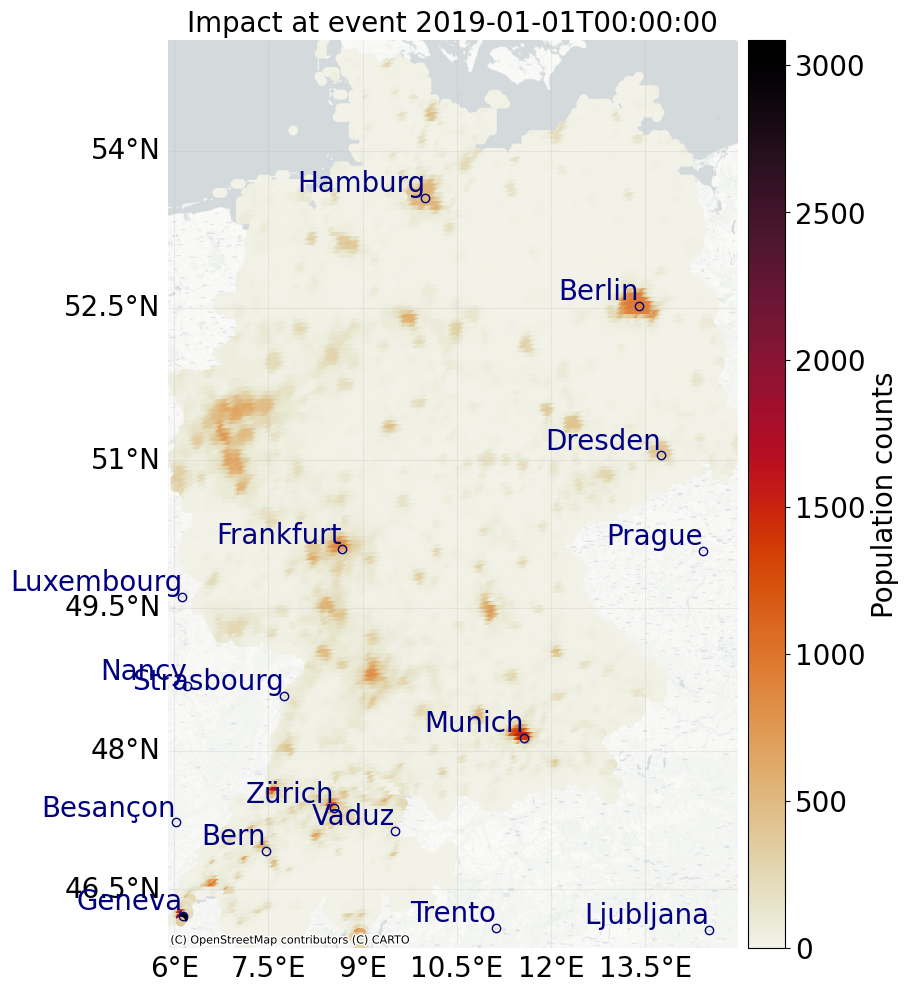

In [57]:
# Plot the impact and exposure with plot_basemap_impact_exposure()

heat_waves_impact.plot_basemap_impact_exposure(
    event_id=33, **{"title": f"Impact at event {heat_waves_impact.event_name[33]}"}
)

# Save the plot as an image
filename = f"{DATADIR}/heat_waves_impact_exposure_basemap.png"
plt.ylabel("Population counts")
plt.savefig(filename, dpi=300, bbox_inches="tight")

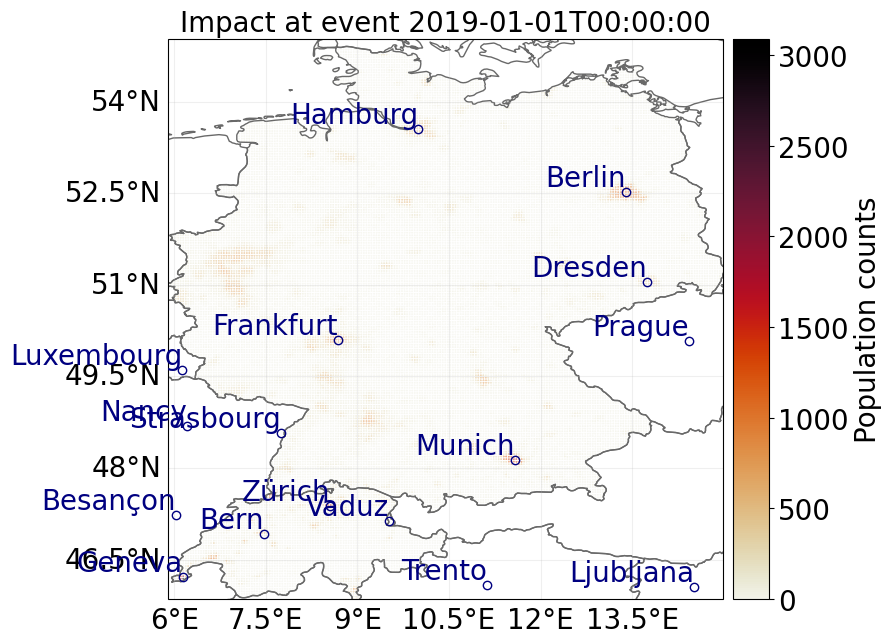

In [58]:
# Plot the impact and exposure with plot_hexbin_impact_exposure

heat_waves_impact.plot_hexbin_impact_exposure(
    event_id=33,
    adapt_fontsize=True,
    **{"title": f"Impact at event {heat_waves_impact.event_name[33]}"},
)

# Save the plot as an image
filename = f"{DATADIR}/heat_waves_impact_exposure_hexbin.png"
plt.ylabel("Population counts")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Save impacts results

The Impact class in CLIMADA provides several methods to save the impact data:
1. write_excel(): This method saves the impact data to an Excel file. The file will contain one sheet with event impact and one with impact summary.
2. write_csv(): This method saves the impact data to a CSV file.
3. write_mat(): This method saves the impact data to a MATLAB .mat file.
4. write_hdf5(): This method saves the impact data to a HDF5 file.

Please take a look at some examples below.

>**Tip:** For optimal performance in saving and retrieving data, we recommend using the .h5 format with CLIMADA. While multiple formats are available for saving data, the .h5 format is the most efficient.

In [59]:
# Save the impact data as a sparse matrix
filename = f"{DATADIR}/heat_waves_impact_NPZ.npz"
heat_waves_impact.write_sparse_csr(filename)

In [60]:
# Save the impact data as csv
filename = f"{DATADIR}/heat_waves_impact_CSV.csv"
heat_waves_impact.write_csv(filename)

In [61]:
# Save the impact data to a HDF5 file

import h5py
import numpy as np
from scipy.sparse import csr_matrix

# Convert the impact data to a NumPy array
impact_data = heat_waves_impact.imp_mat.todense()

# Save the impact data to a HDF5 file
filename_h5 = f"{DATADIR}/heat_waves_impact_H5.h5"
with h5py.File(filename_h5, "w") as file:
    file.create_dataset("impact_data", data=impact_data)

# Read the impact data from the HDF5 file
with h5py.File(filename_h5, "r") as file:
    impact_data_h5 = file["impact_data"][:]

In [62]:
filename_h = f"{DATADIR}/heat_waves_impact_l.h5"
heat_waves_impact.write_hdf5(filename_h)

The saved results can always be retrieved and displayed, for example, using impact.read_csv. From there, they can be referenced or plotted again as follows.

In [63]:
# The .csv file can also be scanned using Pandas

# Load the CSV file into a DataFrame
filename = f"{DATADIR}/heat_waves_impact_CSV.csv"
df = pd.read_csv(filename)

# Display the first few rows of the DataFrame
print(df.head())

# Display the last few rows of the DataFrame
print(df.tail())

# Display the shape of the DataFrame (number of rows, number of columns)
print(df.shape)

          haz_type unit     tot_value       aai_agg  event_id  \
0  Heat_waves_days  USD  8.715901e+07  3.537143e+06       1.0   
1              NaN  NaN           NaN           NaN       2.0   
2              NaN  NaN           NaN           NaN       3.0   
3              NaN  NaN           NaN           NaN       4.0   
4              NaN  NaN           NaN           NaN       5.0   

            event_name  event_date  event_frequency frequency_unit  \
0  1986-01-01T00:00:00    725007.0         0.002646         1/year   
1  1987-01-01T00:00:00    725372.0         0.002730            NaN   
2  1988-01-01T00:00:00    725737.0         0.002799            NaN   
3  1989-01-01T00:00:00    726103.0         0.002772            NaN   
4  1990-01-01T00:00:00    726468.0         0.002814            NaN   

        at_event  eai_exp    exp_lat   exp_lon  \
0  812966.582060      0.0  53.604167  6.687500   
1  835951.864874      0.0  53.604167  6.729167   
2  857348.820655      0.0  53.604167  

2024-09-13 21:50:58,060 - climada.engine.impact - WARNING - The use of Impact.read_csv is deprecated.Use Impact.from_csv instead.
2024-09-13 21:50:58,091 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


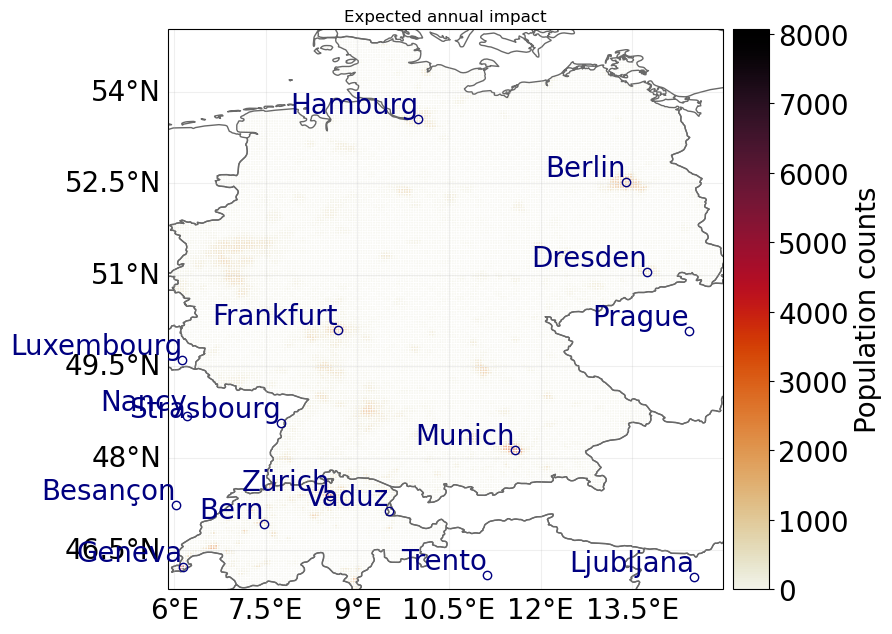

In [64]:
# Read the CSV file using Impact's read_csv method
impact_from_csv = Impact()
filename = f"{DATADIR}/heat_waves_impact_CSV.csv"
impact_from_csv.read_csv(filename)

# Plot using plot_hexbin_eai_exposure
ax = impact_from_csv.plot_hexbin_eai_exposure()
plt.ylabel("Population counts")
plt.show()

## Evaluating Vulnerability Metrics for Targeted Urban Areas (Point Data)

We can also calculate the impact for specific cities. To do this, we use the coordinates of the cities to generate the centroids that enable impact estimation. We then plot the "Impact Exceedance Frequency Curve" to compare and learn how frequently the impact of heat waves exceeds a certain threshold, affecting the population in these areas. For this analysis, we have chosen five cities: Berlin, Zurich, Munich, Geneva, and Hamburg.

> **Note**: The "Impact Exceedance Frequency Curve" graphically depicts risk by showing how often certain impact levels are surpassed. The Y-axis represents impact levels, while the X-axis shows return periods, which indicate the average time between significant impacts. The curve is calculated by dividing the number of events exceeding a given impact by the total events. 

> **Tip**: To interpret the curve, keep these key aspects in mind:

   > - A point on the curve shows that the impact level on the Y-axis is exceeded with a frequency indicated on the X-axis.
   > - An ascending curve signifies that higher impact levels occur less frequently.
   > - The curve aids in risk assessment by displaying the likelihood of various impact levels.

2024-09-13 21:51:12,818 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2024-09-13 21:51:12,847 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2024-09-13 21:51:12,867 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2024-09-13 21:51:12,883 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2024-09-13 21:51:12,907 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


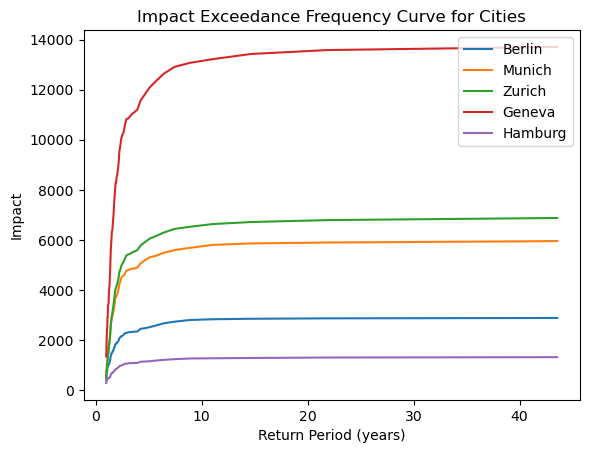

In [65]:
from climada.entity import Exposures

# Define coordinates of the five cities (latitude, longitude)
cities_coords = {
    "Berlin": [52.5200, 13.4050],
    "Munich": [48.1351, 11.5820],
    "Zurich": [47.3769, 8.5417],
    "Geneva": [46.2044, 6.1432],
    "Hamburg": [53.5511, 9.9937],
}

# Initialize a dictionary to store impact objects for each city
city_impacts = {}

# Loop through each city to calculate its impact
for city, coords in cities_coords.items():
    lat, lon = coords

    # Find the closest centroid to the city coordinates
    distance_to_target = np.sqrt(
        (exposure.gdf.latitude - lat) ** 2 + (exposure.gdf.longitude - lon) ** 2
    )
    closest_idx = distance_to_target.idxmin()

    # Create a new exposure object containing only this centroid
    exposure_city = Exposures(exposure.gdf.loc[[closest_idx]])

    # Assign the centroids of hazard events to the new exposure data
    exposure_city.assign_centroids(hazard)

    # Calculate the impact for this city
    impact = Impact()
    impact.calc(exposure_city, if_set, hazard)

    # Store the impact object in the dictionary
    city_impacts[city] = impact

# Initialize a plot for frequency curves
fig, ax = plt.subplots()

# Loop through each city to plot its frequency curve
for city, impact in city_impacts.items():
    impact.calc_freq_curve().plot(axis=ax, label=city)

# Customize the plot
ax.set_title("Impact Exceedance Frequency Curve for Cities")
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Impact")
ax.legend()

# Show the plot
plt.show()

## Write a NetCDF

In [66]:
from save_read_impact_data_to_NetCDF import (
    save_impact_data_to_NetCDF,
    ImpactReaderNetCDF,
)

> **Note**: You can now use the function **save_read_impact_data_to_NetCDF** to save the expected impact results for a typical year or the entire impact matrix, which can later be visualized in any GIS software or NetCDF file reader. If you select **include_imp_mat** and **include_eai_exp** as true, then both will be saved.

In [67]:
save_impact_data_to_NetCDF(
    heat_waves_impact,
    "output_5.nc",
    include_eai_exp=True,
    include_imp_mat=True,
    log_scale_imp=False,
    log_scale_eai=False,
    time_attribute="event_name",
)

Data saved to NetCDF file at C:\Users\jimmy\Documents\RA\CDS_Warm_up\CDS_Warm_Up\output_5.nc


## Read NetCDF file

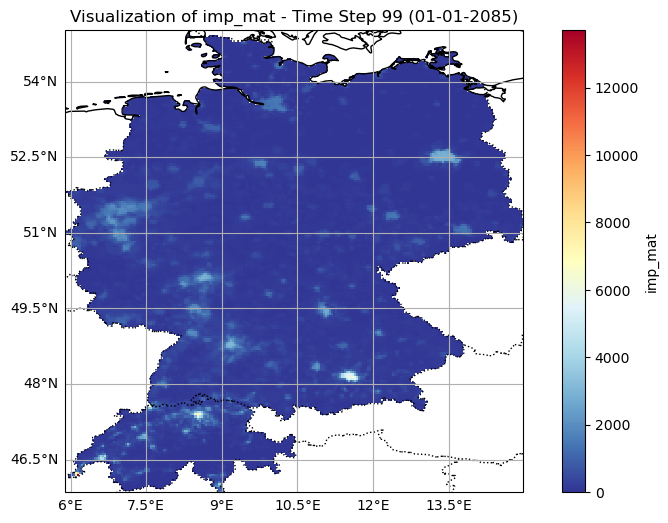

In [68]:
# Read NetCDF file
reader = ImpactReaderNetCDF("output_5.nc")
reader.read_netcdf()
reader.visualize(
    data_type="imp_mat", time_step=99, scale="lineal"
)  # Make sure the path and filename are correctly set
# reader.visualize(data_type='eai_exp', scale='lineal')

## Write GeoTIFF File

In [69]:
from impactWriteReadGeoTIFF import ImpactWriteGeoTIFF, ImpactReaderGeoTIFF

In [70]:
# Save the impact data to a GeoTIFF file
visualizer = ImpactWriteGeoTIFF(heat_waves_impact)
filename = f"{DATADIR}/impact_data_11.tif"
visualizer.write_to_geotiff(filename)

## Read GeoTIFF File

In [71]:
# Read GeoTIFF file
filename = f"{DATADIR}/impact_data_11.tif"
visualizer = ImpactReaderGeoTIFF(filename)
visualizer.plot_geotiff(scale="log")  # For logarithmic scale

# Resume

This tutorial focused on exploring and processing Copernicus data to assess the impact of heatwaves in Germany, Austria, and Switzerland using CLIMADA. The main goal was to guide users through accessing climate data from Copernicus, processing it to create a hazard object, and calculating the potential impacts of heatwaves on populations.

You worked with EURO-CORDEX data to model heatwave patterns over the next century, enabling long-term climate projections. The tutorial also introduced tools for estimating exposure, where datasets like LitPop and Worldpop were used to quantify the number of people at risk. Using these datasets, you learned to create hazard objects, which served as the foundation for calculating impacts such as the Mean Damage Ratio (MDR) and Proportion of Assets Affected (PAA).

Finally, mapping and visualization techniques allowed you to identify high-risk areas, making it easier to understand the distribution of impacts. By completing this tutorial, you gained practical experience in working with Copernicus data to create hazard models and assess climate-related risks using CLIMADA